# Program in the CTH Trigger Logic

In [1]:
%pylab inline
%run visualizations.ipynb
import sys
sys.path.insert(0, '../modules')
from pprint import pprint

Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib


In [2]:
from tracking import HoughSpace
from scipy import sparse
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.ticker as mtick
from hits import CyDetHits, CTHHits, CDCHits

## Import Data

In [3]:
# Test on signal or background data files
test_sig = True

In [4]:
file_base = "/home/elg112/ICEDUST_old/track_finding_standalone/"\
            "track_finding_yandex/data/"
cdc_sig_file = file_base + "after_sum_hit_cth.root"
cth_sig_file = cdc_sig_file

In [5]:
if test_sig:
    hits_cydet = CyDetHits(cdc_sig_file, 
                       tree="CDCHitTree",
                       branches=["MCPos.fP.fX", "MCPos.fP.fY","MCPos.fP.fZ", "MCPos.fE"])
    hits_cth = CTHHits(cth_sig_file, 
                       tree="CTHHitTree",
                       branches=["MCPos.fP.fX","MCPos.fP.fY","MCPos.fP.fZ"],
                       empty_branches=["CTHHit.fIsTrig"])
else:
    hits_cydet = CyDetHits('../data/151208_SimChen_noise.root', signal_coding=[1], branches=["x", "y"])
    hits_cth = CTHHits('../data/151208_SimChen_noise.root', signal_coding=[1], branches=["x", "y"])

In [6]:
hits = CDCHits(hits_cydet, hits_cth)

from cylinder import CyDet
geom = CyDet()
n_events = hits_cth.n_events
print "Start Events: {}".format(hits.cth.n_events)

Start Events: 4021


## Apply All Cuts

In [7]:
# Define cuts to use
n_hits_cut = False
layer_cut = False
timing_cut = False
use_cth_cut = True

In [8]:
if timing_cut:
    # Apply the timing filter
    print "CTH Hits: {}".format(hits.cth.n_hits)
    print "CyDet Hits: {}".format(hits.cydet.n_hits)
    hits.cth.trim_hits(variable=hits.cth.time_name, less_than=1100, greater_than=700)
    hits.cydet.trim_hits(variable=hits.cydet.time_name, less_than=1620, greater_than=700)
    print "CTH Hits: {}".format(hits.cth.n_hits)
    print "CyDet Hits: {}".format(hits.cydet.n_hits)

In [9]:
hits.print_branches()

CTH Branches:
Branches available are:
CTHHit.fMCPos.fP.fX
CTHHit.fMCPos.fP.fY
CTHHit.fMCPos.fP.fZ
CTHHit.fIsSig
CTHHit.fEventNumber
CTHHit.fhits_index
CTHHit.fevent_index
CTHHit.fIsTrig
CTHHit.fTrigTime
CTHHit.fvol_id
CTHHit.fCharge
CTHHit.fMCPos.fE
CyDet Branches:
Branches available are:
CDCHit.fMCPos.fP.fX
CDCHit.fMCPos.fP.fY
CDCHit.fMCPos.fP.fZ
CDCHit.fMCPos.fE
CDCHit.fIsSig
CDCHit.fEventNumber
CDCHit.fhits_index
CDCHit.fevent_index
CDCHit.fTrigTime
CDCHit.fvol_id
CDCHit.fCharge
CDCHit.fDetectedTime


In [10]:
# Filter for CTH in time window.  Get the time
trigger_events = []
for evt in range(hits.n_events):
    sig_hits = hits.cth.get_signal_hits(evt)
    evt_index = np.unique(hits.cth.get_measurement(evt, "CTHHit.fEventNumber"))[0]
    if len(sig_hits) != 0:
        trigger_events.append(evt_index)
trigger_events = np.array(trigger_events)
print "Events that pass CTH Trigger: {}".format(len(trigger_events))

Events that pass CTH Trigger: 3798


In [11]:
# Filter for max layer is five
max_layer = []
for evt in range(hits.n_events):
    these_layers = hits.cydet.geom.point_layers[hits.cydet.get_sig_wires(evt)]
    if len(hits.cydet.get_sig_wires(evt)) != 0:
        max_layer.append(np.max(these_layers))
    else:
        max_layer.append(-1)
max_layer = np.array(max_layer)
good_max_layer = np.where(max_layer >= 4)[0]
print "Number that pass layer cut: {}".format(len(good_max_layer))

Number that pass layer cut: 3303


In [12]:
# Filter for number of signal hits
n_signal_hits  = np.array([len(hits.cydet.get_signal_hits(evt)) 
                         for evt in range(hits.n_events)])
n_signal_hits = np.array(n_signal_hits)
good_n_hits = np.where(n_signal_hits > 30)[0]
print "Number that pass n hits cut: {}".format(len(good_n_hits))

Number that pass n hits cut: 3480


In [13]:
# Apply quality and CTH cuts
print "Start Events: {}".format(hits.n_events)
if use_cth_cut:
    hits.trim_events(trigger_events)
    print "After CTH Trigger {}".format(hits.n_events)
if layer_cut:
    hits.trim_events(good_max_layer)
    print "After Layer Cut Trigger {}".format(hits.n_events)
if n_hits_cut:
    hits.trim_events(good_events)
    print "Afterb N Hits Cut Trigger {}".format(hits.n_events)

Start Events: 4021
After CTH Trigger 3798


In [14]:
print hits.cth.all_branches

['CTHHit.fMCPos.fP.fX', 'CTHHit.fMCPos.fP.fY', 'CTHHit.fMCPos.fP.fZ', 'CTHHit.fIsSig', 'CTHHit.fEventNumber', 'CTHHit.fhits_index', 'CTHHit.fevent_index', 'CTHHit.fIsTrig', 'CTHHit.fTrigTime', 'CTHHit.fvol_id', 'CTHHit.fCharge', 'CTHHit.fMCPos.fE']


# CTH Plots

In [15]:
vol_id_name = "CTHHit.fvol_id"
x_pos_name = "CTHHit.fMCPos.fP.fZ"
y_pos_name = "CTHHit.fMCPos.fP.fY"
t_pos_name = "CTHHit.fMCPos.fE"
hits.cth.data[x_pos_name] = - (hits.cth.data[x_pos_name]/10. - 765)
hits.cth.data[y_pos_name] = hits.cth.data[y_pos_name]/10.

In [16]:
cydet_vol_id_name = "CDCHit.fvol_id"
cydet_z_pos_name = "CDCHit.fMCPos.fP.fX"
cydet_x_pos_name = "CDCHit.fMCPos.fP.fZ"
cydet_y_pos_name = "CDCHit.fMCPos.fP.fY"
cydet_t_pos_name = "CDCHit.fMCPos.fE"
hits.cydet.data[cydet_x_pos_name] = - (hits.cydet.data[cydet_x_pos_name]/10. - 765)
hits.cydet.data[cydet_y_pos_name] = hits.cydet.data[cydet_y_pos_name]/10.
hits.cydet.data[cydet_z_pos_name] = (hits.cydet.data[cydet_z_pos_name]/10. - 641)

In [17]:
def get_crystal_coincidence(vol_types, geom):
    
    return np.logical_or(hit_and_left, hit_and_right)

In [18]:
def get_trigger_signal(vol_types, geom):
    # Get all volumes with pairs
    hit_and_left = np.logical_and(vol_types, vol_types[geom.shift_wires(1)])
    hit_and_right = np.logical_and(vol_types, vol_types[geom.shift_wires(-1)])
    trig_crys = np.logical_or(hit_and_left, hit_and_right)
    # Get volumes with crystals hit above or below
    on_top = np.logical_and(trig_crys[geom.cher_crys], 
                            trig_crys[geom.scin_crys])
    trig_crys[geom.cher_crys] = on_top
    trig_crys[geom.scin_crys] = on_top
    # Include the crystals to the left and right of these volumes
    trig_crys = np.logical_or.reduce((trig_crys, 
                                      trig_crys[geom.shift_wires(1)],
                                      trig_crys[geom.shift_wires(-1)]))
    # Return the volumes that pass and have hits
    return np.logical_and(vol_types, trig_crys)    

In [19]:
hits.print_branches()

CTH Branches:
Branches available are:
CTHHit.fMCPos.fP.fX
CTHHit.fMCPos.fP.fY
CTHHit.fMCPos.fP.fZ
CTHHit.fIsSig
CTHHit.fEventNumber
CTHHit.fhits_index
CTHHit.fevent_index
CTHHit.fIsTrig
CTHHit.fTrigTime
CTHHit.fvol_id
CTHHit.fCharge
CTHHit.fMCPos.fE
CyDet Branches:
Branches available are:
CDCHit.fMCPos.fP.fX
CDCHit.fMCPos.fP.fY
CDCHit.fMCPos.fP.fZ
CDCHit.fMCPos.fE
CDCHit.fIsSig
CDCHit.fEventNumber
CDCHit.fhits_index
CDCHit.fevent_index
CDCHit.fTrigTime
CDCHit.fvol_id
CDCHit.fCharge
CDCHit.fDetectedTime


In [20]:
def set_trigger_vols(cth_hits, event):
    # Get the volumes with hits for these events
    cth_vol_types = cth_hits.get_vol_types(event)
    vols_with_trig = np.nonzero(get_trigger_signal(cth_vol_types, cth_hits.geom))
    vol_trig_hits = cth_hits.filter_hits(cth_hits.get_events(event), "CTHHit.fvol_id", 
                                         values=vols_with_trig)["CTHHit.fhits_index"]
    # Get the timing of the fourth volume hit
    if sum(vols_with_trig) != 0:
        _, uniq_idxs = np.unique(cth_hits.data["CTHHit.fvol_id"][vol_trig_hits], 
                                   return_index=True)
        print uniq_idxs
        uniq_idxs = uniq_idxs[uniq_idxs > 2] 
        print uniq_idxs
        fourth_uniq_hit = uniq_idxs[(np.abs(uniq_idxs-3)).argmin()]
        print fourth_uniq_hit
        fourth_vol_hit = vol_trig_hits[fourth_uniq_hit]
        cth_hits.data["CTHHit.fTrigTime"][vol_trig_hits] = cth_hits.data[cth_hits.time_name][fourth_vol_hit]

In [21]:
hits.cth.set_trigger_time()

In [23]:
print hits.cth.get_vol_types(10)[:None]
print hits.cth.get_trig_vector(10)[0]

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0

/home/elg112/development/miniconda2/envs/rep/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


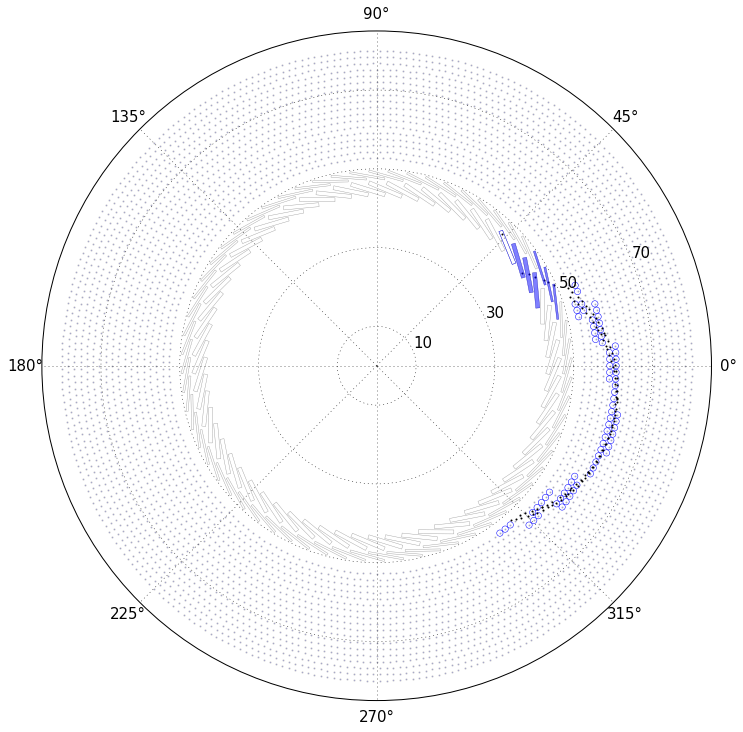

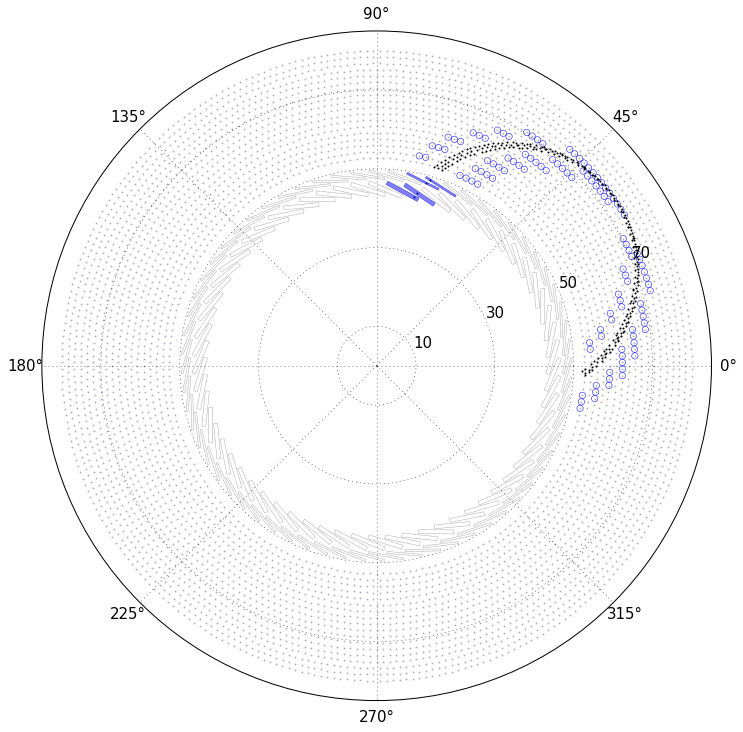

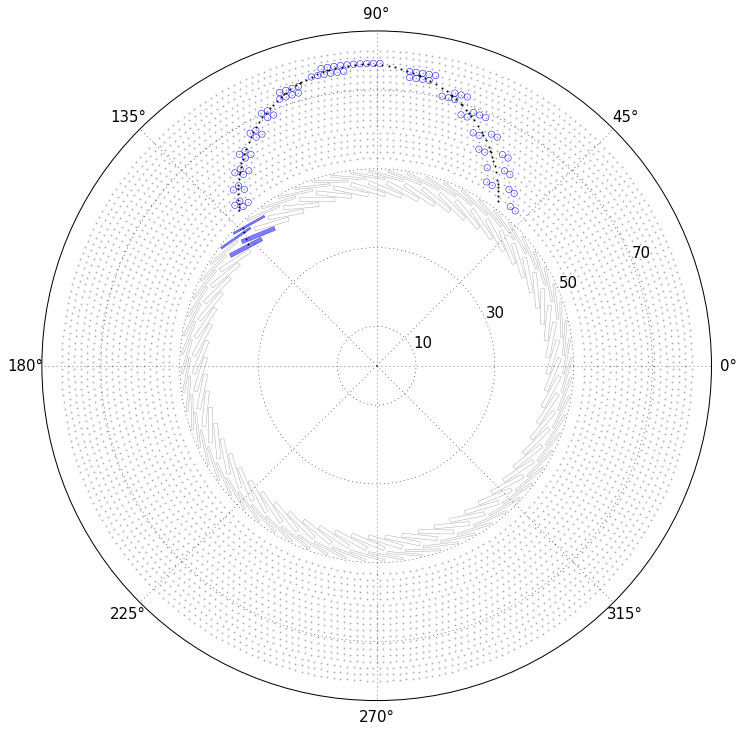

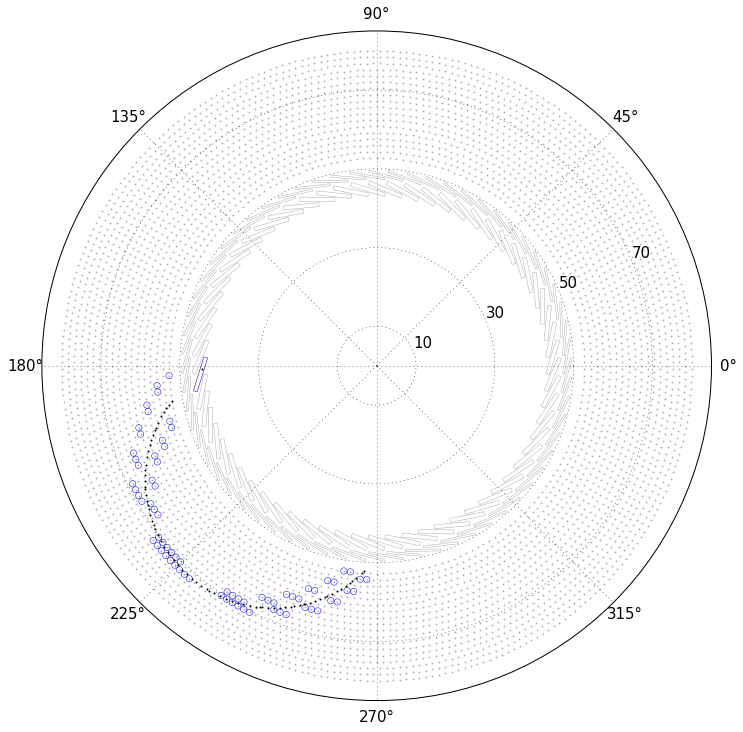

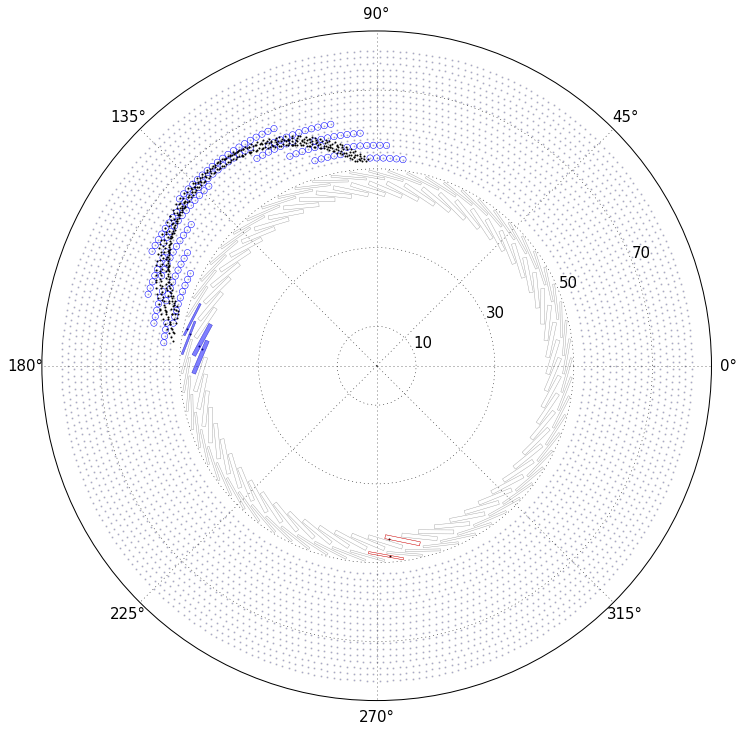

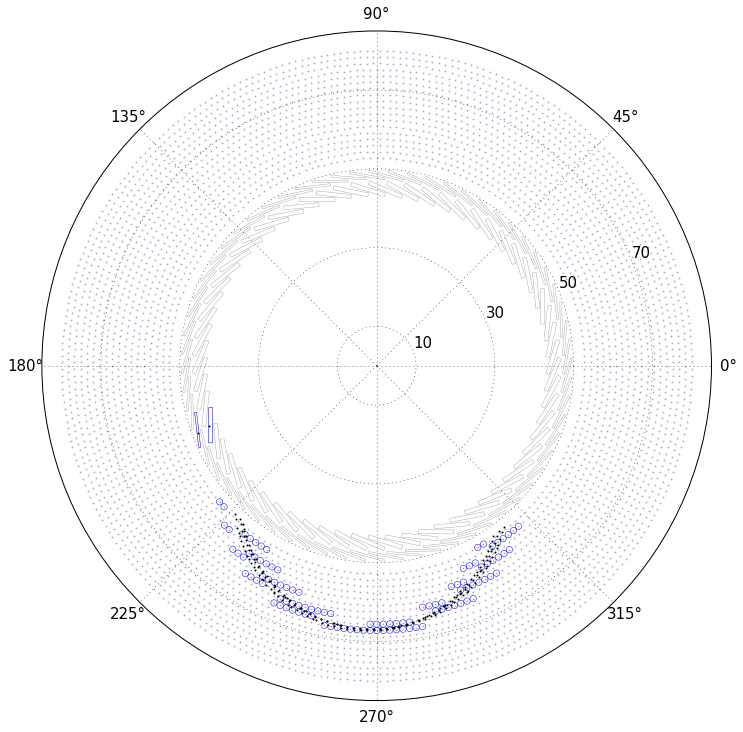

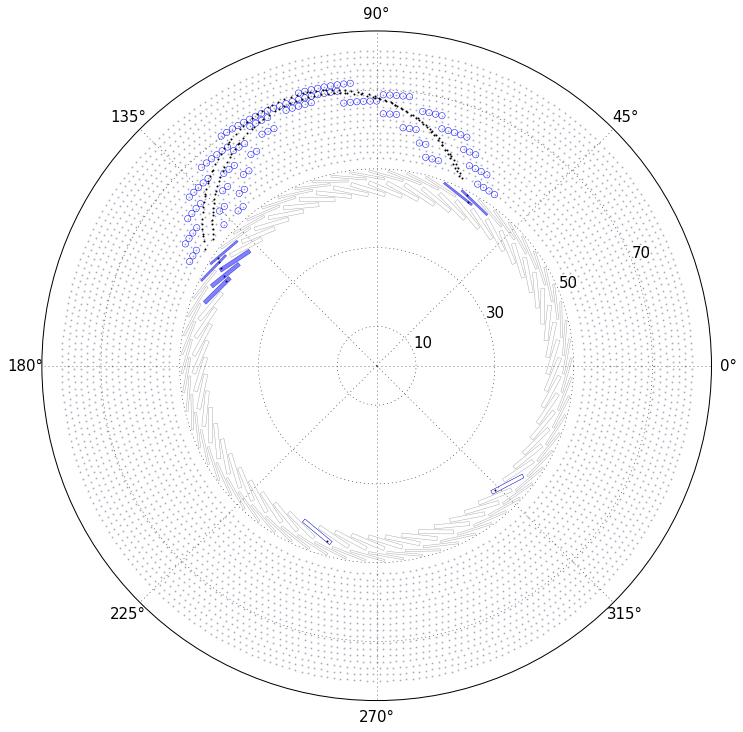

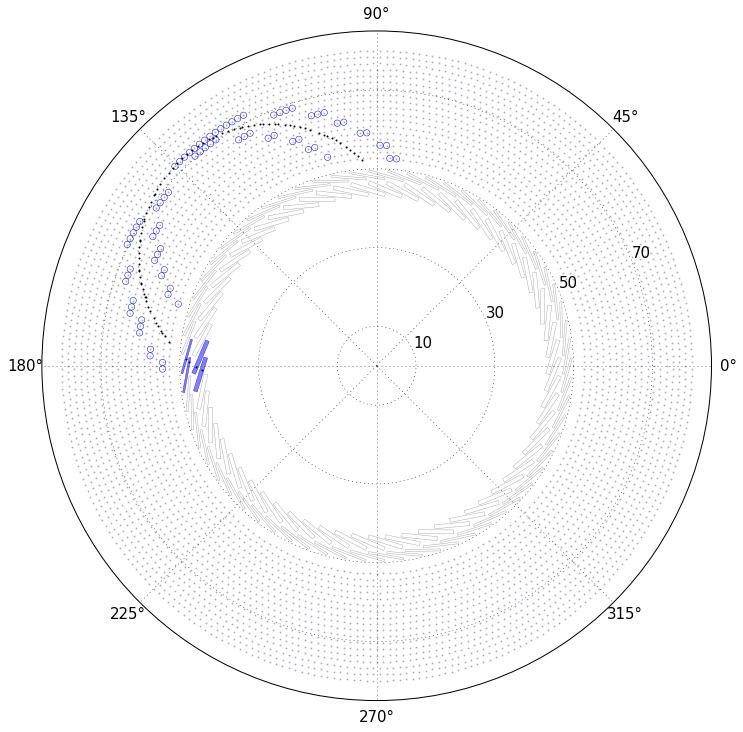

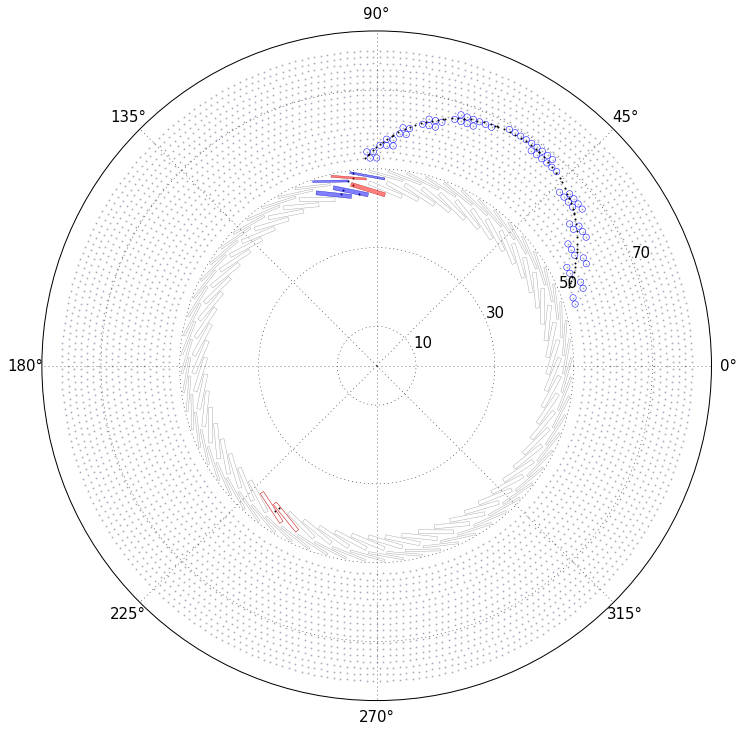

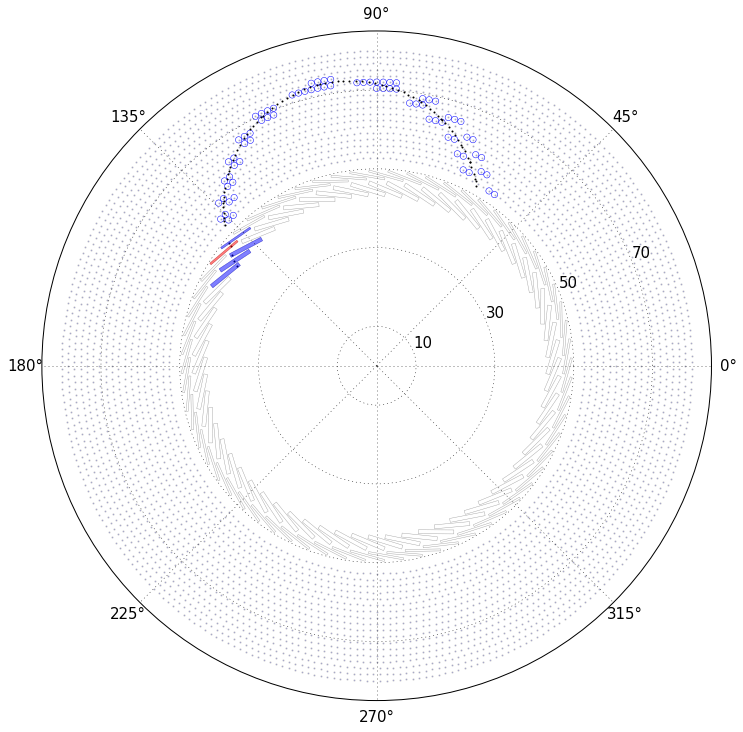

In [24]:
for evt in range(10):
    # Plot the output
    plot_output(np.zeros_like(hits.cydet.get_hit_types(evt)), geom)
    # Add hit outlines
    plot_add_outlines(hits.cydet.get_hit_types(evt), geom)
    # Add volume outlines
    plot_add_cth_outlines(hits.cth.geom)
    # Add the CTH vols with hits
    cth_vol_types = hits.cth.get_vol_types(evt)
    plot_add_cth(cth_vol_types, hits.cth.get_trig_vector(evt)[0], hits.cth.geom)
    cth_hits = hits.cth.get_events(evt)
    cdc_hits = hits.cydet.get_signal_hits(evt)
    plt.scatter(cth_hits[x_pos_name], cth_hits[y_pos_name], s=1, transform=gca().transData._b)
    plt.scatter(cdc_hits[cydet_x_pos_name], cdc_hits[cydet_y_pos_name], s=1, transform=gca().transData._b)
    plt.show()

In [25]:
print hits.cth.get_events(events=12)[hits.cth.time_name]

[ 1533.92816162  1533.97698975  1534.01025391  1534.08789062  1534.1461792
  1536.55322266]
